In [ ]:
!pip install -q "transformers==4.41.2" "datasets==2.20.0" "accelerate==0.31.0" --upgrade

In [ ]:
from datasets import load_dataset

ds = load_dataset("AI-Lab-Makerere/beans")
ds

In [ ]:
example = ds['train'][900]
example

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.286.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 2}

In [69]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

using int2str function to get name of the label for the example

In [70]:
labels.int2str(example['labels'])

'healthy'

In [73]:
labels = ds['train'].features['labels'].names
labels

['angular_leaf_spot', 'bean_rust', 'healthy']

display a grid of examples from each class

In [ ]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

Above what I'm seeing,
*   Angular Leaf Spot: Has irregular brown patches
*   Bean Rust: Has circular brown spots surrounded with a white-ish yellow ring
*   Healthy: ...looks healthy.









In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing pixel values, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the return_tensors='pt' argument, we'll get back torch tensors instead.

In [ ]:
feature_extractor(example['image'], return_tensors='pt')

# Processing the Dataset

In [74]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(ds['train'][0])

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds['train'][0:2]

# Training and Evaluation

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.048700,0.107470,0.977444
200,0.012800,0.039786,0.992481


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1165
  train_runtime            =  2:32:54.82
  train_samples_per_second =       0.451
  train_steps_per_second   =       0.028


In [22]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0398
  eval_runtime            = 0:01:54.30
  eval_samples_per_second =      1.164
  eval_steps_per_second   =      0.149


# Prediction

In [63]:
import requests
import matplotlib.pyplot as plt

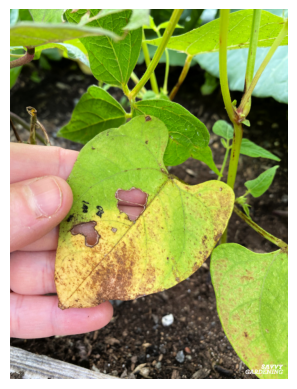

In [64]:
url = 'https://i0.wp.com/savvygardening.com/wp-content/uploads/2022/07/bean-leaf-turning-yellow.jpg?resize=600%2C800&ssl=1'
# url =  'https://cdn.dotpe.in/longtail/store-items/460859/9gSQhH1i.jpeg'
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

inputs = feature_extractor(images=image, return_tensors='pt')

In [65]:
# Make sure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted class
logits = outputs.logits
# print(logits)
predicted_class_idx = logits.argmax(-1).item()

print(f"Predicted class index: {predicted_class_idx}")


Predicted class index: 0


In [66]:
labels[predicted_class_idx]

'angular_leaf_spot'

Predicted class index: 2


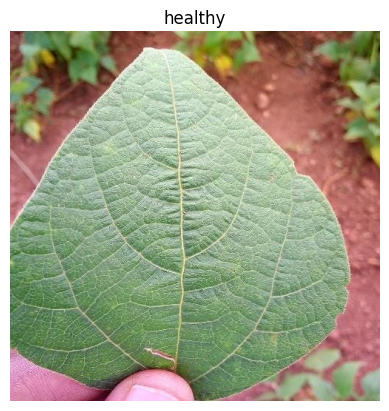

In [67]:
url = 'https://miro.medium.com/v2/resize:fit:1000/0*ULGbMsWMYBf-VoDB.jpeg'
image = Image.open(requests.get(url, stream=True).raw)
inputs = feature_extractor(images=image, return_tensors='pt')

model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted class
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

print(f"Predicted class index: {predicted_class_idx}")
label = labels[predicted_class_idx]

plt.imshow(image)
plt.axis('off')
plt.title(label)
plt.show()